In [1]:
from fastai.vision.all import *
from fastai.tabular.all import *

In [2]:
PATH = Path('../input/optiver-realized-volatility-prediction')

# data_df = pd.read_parquet(PATH/'book_train_reindexed.parquet')

# sizes = ['bid_size1', 'bid_size2', 'ask_size1', 'ask_size2']
# for sz in sizes:
#     data_df[sz] = data_df[sz]/ 1_000_000



In [3]:
#train_df = pd.read_csv(PATH/'train_with_offset.csv')
# data_df['wap'] = (data_df.bid_price1 * data_df.ask_size1 + data_df.ask_price1 * data_df.bid_size1) / (data_df.ask_size1 + data_df.bid_size1)

# mean_wap =[]
# for row in train_df.itertuples():
#     df = data_df.iloc[row.offset:row.offset+600]
#     mean_wap.append(df.wap.mean())

In [4]:
# train_df['mean_wap']=mean_wap
# train_df.to_csv(PATH/'train_with_wap.csv')

In [5]:
# np_data = data_df[['bid_price1', 'ask_price1', 'bid_size1', 'ask_size1','bid_price2', 'ask_price2', 'bid_size2', 'ask_size2']].to_numpy()

# del data_df

# np_data = np_data.astype('float32')
# torch_data = torch.tensor(np_data)

# del np_data

# torch.save(torch_data, PATH/'torch_data.pth')

In [6]:
%%time
torch_data = torch.load(PATH/'torch_data.pth')

for i in (2,3,6,7): torch_data[:,i] *= 1_000_000

CPU times: user 3.66 s, sys: 12 s, total: 15.7 s
Wall time: 1min 56s


In [7]:
bid_price1, ask_price1, bid_size1, ask_size1,bid_price2, ask_price2, bid_size2, ask_size2 = [torch_data[:,i] for i in range(8)]

In [8]:
wap = (bid_price1 * ask_size1 + ask_price1 * bid_size1)/(bid_size1 + ask_size1)
wap2 = (bid_price2 * ask_size2 + ask_price2 * bid_size2)/(bid_size2 + ask_size2)
wap_balance = wap - wap2
price_spread =  (ask_price1 - bid_price1) / ((ask_price1 + bid_price1)/2)
bid_spread = bid_price1 - bid_price2
ask_spread = ask_price1 = ask_price2
total_volume = ask_size1+ask_size2 +bid_size1 + bid_size2
volume_imbalance = (ask_size1 + ask_size2) - (bid_size1 + bid_size2)
feats= torch.stack([wap, wap2, wap_balance, price_spread, bid_spread, ask_spread, total_volume, volume_imbalance])
feats.shape

torch.Size([8, 257359200])

In [9]:
torch_data = torch.cat([torch_data, feats.T], dim=1)
torch_data.shape

torch.Size([257359200, 16])

In [10]:
del bid_price1, ask_price1, bid_size1, ask_size1,bid_price2, ask_price2, bid_size2, ask_size2,wap, wap2, wap_balance, price_spread, bid_spread, ask_spread, total_volume, volume_imbalance,feats

In [11]:
means, stds = torch_data.mean(dim=0), torch_data.std(dim=0)
print(means, stds)
torch_data = (torch_data - means) / stds

tensor([ 9.9968e-01,  1.0003e+00,  7.6999e+02,  7.6673e+02,  9.9948e-01,
         1.0005e+00,  9.5934e+02,  9.2822e+02,  1.0000e+00,  1.0000e+00,
         1.2723e-06,  6.6282e-04,  1.9751e-04,  1.0005e+00,  3.4243e+03,
        -3.4377e+01]) tensor([3.6881e-03, 3.6871e-03, 5.3541e+03, 4.9549e+03, 3.7009e-03, 3.6991e-03,
        6.6838e+03, 5.7353e+03, 3.6899e-03, 3.7075e-03, 5.1506e-04, 7.6403e-04,
        2.5716e-04, 3.6991e-03, 2.0439e+04, 6.1751e+03])


In [12]:
train_df = pd.read_csv(PATH/'train_with_wap.csv')

train_ftrs = pd.read_csv(PATH/'train_with_ftrs.csv')
train_ftrs.stock_id = train_ftrs.stock_id.astype('category')


train_ftrs = train_ftrs.drop(['stock_id_target_enc', 'row_id', 'target'], axis=1)
train_df = train_df.drop(['stock_id'], axis=1)

train_df = pd.concat([train_df, train_ftrs], axis=1)

In [13]:
w = train_df.mean_wap.to_numpy()

w =np.sort(w)

bins = []

step = (len(w)+9)//10
for i in range(0, len(w), step):
    j = min(i+step, len(w))
    bins.append(w[j] if j< len(w) else 2)
    print(w[i], w[j-1],np.median(w[i:j]) )

wap_bin = np.digitize(train_df.mean_wap, bins)

train_df['wap_bin']=wap_bin

0.9172531180048944 0.9971951138775056 0.9956492523836432
0.9971951327900604 0.9984703256953886 0.9979708959569917
0.9984703751656142 0.9991431543863876 0.9988451162091514
0.9991431683337992 0.999616836138266 0.9993924853218963
0.9996168497680276 1.0000141933324718 0.9998199779860442
1.0000141975255898 1.0004091980748968 1.00020793857736
1.0004091986325243 1.000876884050013 1.0006291062379966
1.0008769297217603 1.0015230362748495 1.0011664016312456
1.0015230933064834 1.002768629281105 1.0020189286622183
1.0027686365447124 1.077264872305151 1.004330146304397


In [14]:
w = train_df.target.to_numpy()

w =np.sort(w)

bins = []
bin_med=[]
step = (len(w)+9)//10
for i in range(0, len(w), step):
    j = min(i+step, len(w))
    bins.append(w[j] if j< len(w) else 1)
    bin_med.append(np.median(w[i:j]))
    print(w[i], w[j-1],np.median(w[i:j]) )

target_bin = np.digitize(train_df.target, bins)

train_df['target_bin']=target_bin

0.000105263 0.001436988 0.001175852
0.001436991 0.001838282 0.0016455530000000001
0.001838308 0.002210492 0.0020263215
0.002210493 0.002604845 0.00240206
0.002604847 0.003048064 0.002817908
0.003048071 0.003585089 0.0033027735
0.003585105 0.00428704 0.003905317
0.004287042 0.005311553 0.0047378975
0.005311559 0.007240946 0.0060829544999999995
0.007240976 0.07032062 0.009453786499999998


In [15]:
class ResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(ch, ch, kernel_size = 5, padding = 2, padding_mode='replicate'),
            nn.BatchNorm1d(ch),
            nn.ReLU(),
            nn.Conv1d(ch, ch, kernel_size = 5, padding = 2, padding_mode='replicate'),
            nn.BatchNorm1d(ch),
        )
        
    def forward(self, x):
        res = self.layers(x) + x
        res = F.relu(res)
        return res

In [62]:
EMB_DIM = 32

class OptiverModel(nn.Module):
    def __init__(self, conv_in, n_feat, conv_chan=32):
        super().__init__()

        conv_out = 4 * conv_chan
        conv_layers = [nn.Conv1d(conv_in, conv_chan, kernel_size=1)]
        for _ in range(8):
            conv_layers += [ResBlock(conv_chan), ResBlock(conv_chan), ResBlock(conv_chan), ResBlock(conv_chan)
                       , nn.AvgPool1d(2, padding=1),
                      ]
        conv_layers += [Flatten()]#, nn.Dropout(.1)]   
        self.conv_layers = nn.Sequential(*conv_layers)
        
        self.stock_embedding = nn.Embedding(127,EMB_DIM )
        self.emb_drop = nn.Dropout(.25)
        class_inp =  EMB_DIM + n_feat  + conv_out
        self.classifier = nn.Sequential(
            LinBnDrop(class_inp, 400, p = 0, act = nn.ReLU()),
            LinBnDrop(400, 200, p=.25, act = nn.ReLU()), 
            LinBnDrop(200, 1, p=0),
            SigmoidRange(0, .1)
        )
        

    def forward(self, stock_id, features, book_data):
        book_feat = self.conv_layers(book_data)
        stock_emb = self.emb_drop(self.stock_embedding(stock_id)).squeeze()
        x = torch.cat([book_feat, stock_emb, features], dim=1)
        res = self.classifier(x)
        
        return res

In [17]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embeds = nn.Embedding(127, 23)
        self.bn_embs = nn.BatchNorm1d(23)
        self.layers = nn.Sequential(
            LinBnDrop(49,400,act=nn.ReLU(), lin_first=True),
            LinBnDrop(400,200, act=nn.ReLU(), lin_first=True),
            LinBnDrop(200,1,bn=False),
            SigmoidRange(0, .1)
        )
    def forward(self,  stock_id, feats):
        stock_emb = self.embeds(stock_id.squeeze())
        stock_emb = self.bn_embs(stock_emb)
        x = torch.cat([stock_emb, feats], dim=1)
        return self.layers(x)

In [18]:
def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [19]:
def rmspe_loss(preds, targs, reduction='mean'):
    assert reduction == 'mean'
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [20]:
class MyProc(TabularProc):
    def encodes(self, to):
        print(type(to))
        return to
    def __getitem__(self,k):
        print('getting', k)
        return 0

In [21]:
class ReadBatch(ItemTransform):
    def encodes(self, to):
        book_offsets = torch.tensor(to['offset'].to_numpy()).long()
        book_data = torch_data.view(-1,600,16)[book_offsets//600,:,:]
        book_data = book_data.permute(0,2,1)
        res = (tensor(to.cats).long(),tensor(to.conts).float(), book_data)        
        res = res + (tensor(to.targ),)
        if to.device is not None: res = to_device(res, to.device)
        return res

In [22]:

cont_nn,cat_nn = cont_cat_split(train_ftrs, max_card=9000, dep_var='target')
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(train_df, procs_nn, cat_nn, cont_nn,
                      splits=ColSplitter()(train_df), y_names='target')
dls = to_nn.dataloaders(1024, after_batch = ReadBatch)

In [30]:
bx1, bx2,bx3, by = dls.one_batch()

bx1.shape, bx2.shape, bx3.shape, by.shape

(torch.Size([1024, 1]),
 torch.Size([1024, 26]),
 torch.Size([1024, 16, 600]),
 torch.Size([1024, 1]))

In [31]:
model = OptiverModel(16, 26).cuda()

In [32]:
model(bx1.cuda(),bx2.cuda(), bx3.cuda()).shape

torch.Size([1024, 1])

In [41]:
class ResnetModel(nn.Module):
    def __init__(self):
        self.conv_layers = None

In [51]:
def split_2way(model):
    #return L(params(model.initial_conv)+params(model.conv_layers), params(model.classifier))
    return L(params(model.conv_layers), params(model.classifier)+params(model.stock_embedding))

In [63]:
conv_layers = torch.load('resnet_feat.pth').conv_layers

model = OptiverModel(16, 26)
model.conv_layers = conv_layers

#learn = Learner(dls, ConvModel(),loss_func=mspe_loss, metrics=AccumMetric(rmspe))
learn = Learner(dls,model, loss_func=rmspe_loss, splitter = split_2way, metrics=AccumMetric(rmspe))

In [64]:
learn.fine_tune(40,1e-2, freeze_epochs=10)

epoch,train_loss,valid_loss,rmspe,time
0,1.854881,0.981852,1.051296,00:34
1,0.418063,0.290858,0.297915,00:35
2,0.295562,0.246148,0.249975,00:34
3,0.264452,0.236943,0.239977,00:35
4,0.265160,0.255318,0.258538,00:34
5,0.292128,0.240901,0.244153,00:34
6,0.262600,0.249059,0.252417,00:34
7,0.249435,0.232135,0.236028,00:35
8,0.243366,0.231482,0.234321,00:35
9,0.240318,0.227771,0.230703,00:34


epoch,train_loss,valid_loss,rmspe,time
0,0.234227,0.229302,0.232589,00:46
1,0.233879,0.228579,0.231959,00:46
2,0.232129,0.228014,0.230945,00:46
3,0.231994,0.226884,0.231057,00:45
4,0.233270,0.256075,0.385455,00:45
5,0.237201,0.226087,0.229023,00:45
6,0.233280,0.234123,0.259951,00:45
7,0.234662,0.227587,0.233018,00:45
8,0.233539,0.240287,0.244417,00:45
9,0.236044,0.231225,0.233752,00:45


In [ ]:
learn.fit_one_cycle(200, 1e-5)

epoch,train_loss,valid_loss,rmspe,time
0,0.225247,0.534099,2.839925,00:55
1,0.223544,0.555228,2.991100,00:47
2,0.224565,0.224885,0.229341,00:46
3,0.225075,0.543276,2.923365,00:46
4,0.224607,0.448387,2.070324,00:46
5,0.225324,0.234825,0.267979,00:46
6,0.223775,0.246226,0.336828,00:46
7,0.224494,0.513946,2.656829,00:46
8,0.225000,0.365705,1.339112,00:46
9,0.225012,0.236700,0.276204,00:46


In [41]:
learn.save('res_model2.pth')

Path('models/res_model2.pth.pth')

In [42]:
learn.load('res_model2.pth')

#stem = nn.Sequential(*list(learn.model.layers.children())[:-1])
#stem = nn.Sequential(*list(ResnetModel(10).layers.children())[:-1])
#reg_m = ResnetRegression(stem, 6*16)
reg_m = ResnetModel(1,16, do_sigmoid=True)
#reg_m.initial_conv = learn.model.initial_conv
reg_m.conv_layers = learn.model.conv_layers


In [43]:
def split_2way(model):
    #return L(params(model.initial_conv)+params(model.conv_layers), params(model.classifier))
    return L(params(model.conv_layers), params(model.classifier))

In [44]:
learn2 = Learner(dls_reg, reg_m, splitter=split_2way, loss_func=rmspe_loss, metrics=AccumMetric(rmspe))#, cbs=SaveModelCallback(monitor='rmspe', comp=np.less))

In [45]:
learn2.fine_tune(12, 5e-3,freeze_epochs=3)

epoch,train_loss,valid_loss,rmspe,time
0,0.891754,0.544421,0.551181,00:48
1,0.336100,0.304965,0.310994,00:48
2,0.283303,0.265314,0.268234,00:49


epoch,train_loss,valid_loss,rmspe,time
0,0.270342,0.243625,0.246502,00:53
1,0.260375,0.250803,0.254191,00:53
2,0.259777,0.241224,0.243995,00:54
3,0.256703,0.252070,0.254435,00:54
4,0.248544,0.238451,0.241581,00:54
5,0.246554,0.254703,0.257441,00:55
6,0.238894,0.240233,0.242956,00:55
7,0.236193,0.233102,0.235620,00:55
8,0.235442,0.232176,0.235179,00:55
9,0.234337,0.235885,0.238898,00:54


In [34]:
learn2.fit_one_cycle(30, 1e-5)

epoch,train_loss,valid_loss,rmspe,time
0,0.268721,0.231905,0.234752,00:55
1,0.268435,0.234304,0.236889,00:54
2,0.272388,0.231735,0.234371,00:54
3,0.268273,0.233675,0.236370,00:55
4,0.269473,0.236022,0.239170,00:55
5,0.268716,0.234981,0.237562,00:55
6,0.268082,0.232750,0.235397,00:57
7,0.267246,0.234502,0.237406,00:57
8,0.268827,0.231307,0.234133,00:57
9,0.267284,0.232713,0.235279,00:57


In [227]:
learn2 = Learner(dls_reg, ResnetModel(1, do_sigmoid=True), splitter=split_2way, loss_func=rmspe_loss, metrics=AccumMetric(rmspe), wd=.1)

learn2.fit_flat_cos(12, 1e-3, wd=.2)

In [32]:
torch.save(learn2.model, 'resnet_feat.pth')

In [428]:
preds, targs = learn2.get_preds()

rmspe(preds.view(-1), targs)

tensor(0.2422)

In [429]:
preds, targs = learn.get_preds()

In [430]:
predicted_bins = torch.argmax(preds, dim=1)

In [431]:
CI = ClassificationInterpretation.from_learner(learn)

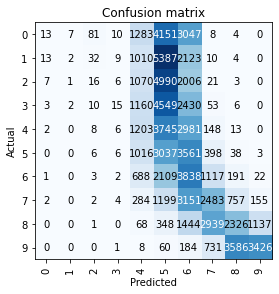

In [432]:
CI.plot_confusion_matrix()

In [433]:
pred_vals =torch.tensor(bin_med)[predicted_bins]

In [434]:
target_vals = dls.valid.items.target.to_numpy()
target_vals = torch.tensor(target_vals)

In [435]:
rmspe(pred_vals, target_vals)

tensor(0.9269, dtype=torch.float64)